# Flare vetting

In [1]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, CustomJS, BoxAnnotation
from bokeh.models.widgets import Button
from bokeh.layouts import row, column
from bokeh.plotting import figure, output_file, show

from altaipony.lcio import from_path

import pandas as pd
import numpy as np

output_notebook()


def interactive_vetting(df, ID, c, flc):
    
    dff = df[(df.EPIC == ID) & (df.Campaign == c)].drop_duplicates()
    
    g = lambda x: flc.detrended_flux[np.where(x.cstart==flc.cadenceno)[0]][0]
    dff["peak"] = dff.apply(g, axis=1)
    dff["desc"] = dff.apply(lambda x: " {}, {}, {};".format(x.cstart, x.EPIC, x.Campaign), axis=1)

    #---------------------------------------------------------------------------------------------------

    LC = pd.DataFrame({"time":flc.time, "flux":flc.detrended_flux})
    LC = LC.set_index("time")

    #---------------------------------------------------------------------------------------------------

    source = ColumnDataSource(LC)
    flares = ColumnDataSource(data=dict(tstart=dff.tstart.values,
                                        peak=dff.peak.values,
                                        desc=dff.desc))



    p = figure(plot_height=350, plot_width=900, title="ID {}, Campaign {}".format(ID, c),
               toolbar_location="right",
               #tools= "pan,wheel_zoom,box_zoom,reset, hover",
                tools="lasso_select", #title="Select Here",
               x_range=(np.min(LC.index.values), np.max(LC.index.values)))

    for i, row in dff.iterrows():

        LCsub = LC.iloc[int(row.istart)-1: int(row.istop)+1,:]
        LCsub["upper"] = np.max(LCsub.index.values)
        LCsub["lower"] = np.min(LCsub.index.values)
        subset = ColumnDataSource(LCsub)
        p2 = BoxAnnotation(left=np.min(LCsub.index.values), 
                           right=np.max(LCsub.index.values), 
                           fill_alpha=0.5, fill_color='red')

        p.renderers.extend([p2])

    p.line('time', 'flux', source=source,line_color="black")
    p.xgrid.visible = False
    p.ygrid.visible = False
    p.circle('tstart', 'peak', source=flares, size=20, alpha=0.6)

    #-------------------------------------------------------------------------------

    s2 = ColumnDataSource(data=dict(tstart=[], peak=[]))
    p2 = figure(plot_width=900, plot_height=300,
                tools="reset,wheel_zoom,box_zoom", title="Watch Here")
    p2.circle('tstart', 'peak', source=s2, size=20, alpha=0.6)
    p2.line('time', 'flux', source=source,line_color="black")

    flares.selected.js_on_change('indices', CustomJS(args=dict(flares=flares, s2=s2,),code="""
            var inds = cb_obj.indices;
            var d1 = flares.data;
            var d2 = s2.data;
            d2['tstart'] = []
            d2['peak'] = []
            for (var i = 0; i < inds.length; i++) {
                d2['tstart'].push(d1['tstart'][inds[i]])
                d2['peak'].push(d1['peak'][inds[i]])
            }
            s2.change.emit();
        """)
    )

    #--------------------------------------------------------------------------
    savebutton = Button(label="Save", button_type="success")
    savebutton.callback = CustomJS(args=dict(source_data=flares), code="""
                var inds = source_data.selected['1d'].indices;
                var data = source_data.data;
                var out = "";
                for (i = 0; i < inds.length; i++) {
                    out += data['desc'][inds[i]] + " ";
                }
                var file = new Blob([out], {type: 'text/plain'});
                var elem = window.document.createElement('a');
                elem.href = window.URL.createObjectURL(file);
                elem.download = 'vetted.txt';
                document.body.appendChild(elem);
                elem.click();
                document.body.removeChild(elem);
                """)

    #-------------------------------------------------------------------
    layout = column(p, p2, savebutton)
    show(layout)

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Loading BokehJS ...

## Choose the cluster

In [2]:
cluster = 'ngc2168'

In [3]:
df = pd.read_csv("../ClusterAnalysis/flares/{}_flares.csv".format(cluster))

In [4]:
df = df.dropna(subset=["ampl_rec", "ed_rec"])
df = df.drop_duplicates()
IDS = df.EPIC.unique()
IDS.shape

(107,)

## Select ID for LC with flares

In [94]:
ID = IDS[15] # M35 next: 
Cs = df.Campaign[df.EPIC == ID].unique()
Cs

array([0.])

## Choose campaign with which to start

In [134]:
c = int(Cs[0])
c= 18
ID = 211416925


## Load light curve to inspect

In [135]:
try:
    flc = from_path("../DetrendedLightCurves/pony_k2sc_k2_llc_{}-c{:02d}_kepler_v2_lc.fits".format(ID, c), mode="AltaiPony", mission="K2")
except:
    flc = from_path("../DetrendedLightCurves/HAT_{}.fits".format(ID), mode="AltaiPony", mission="K2")
flc = flc[np.where(flc.time!=0.)]

/work1/eilin/Flares_in_Clusters_2/Results/AltaiPony/altaipony/lib64/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:139: ResourceWarning: unclosed file <_io.FileIO name='../DetrendedLightCurves/pony_k2sc_k2_llc_211416925-c18_kepler_v2_lc.fits' mode='rb' closefd=True>
  return _from_path_AltaiPony(path)


## Load stellar parameters for a cross-check

In [136]:
params = pd.read_csv("../CDS/stars.csv", names=["ID","C", "RA", "Dec",
                                                "pmem", "outlier", "Teff",
                                                "eTeff", "R", "eR", "LumKepler",
                                                "eLumKepler"])
params[params.ID == ID]

,ID,C,RA,Dec,pmem,outlier,Teff,eTeff,R,eR,LumKepler,eLumKepler
3303,211416925,18,132.49227,11.895616,0.89,-999,3813,79,0.54,0.07,9.355915e+30,2.446371e+30


## Look at the light curve: Weird or not?

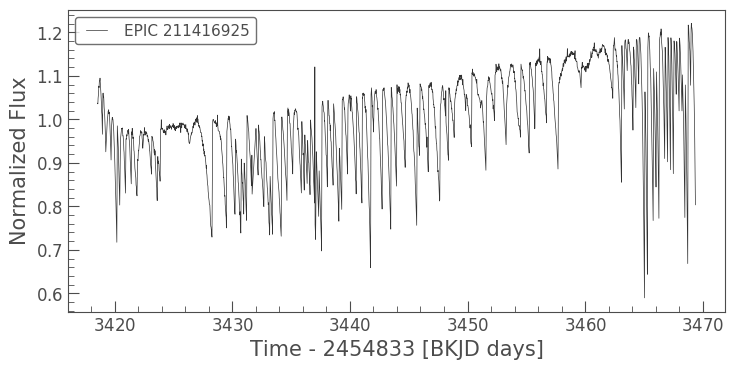

In [137]:
flc.plot()

In [138]:
flc.flux.std()

63.674686

(600, 650)

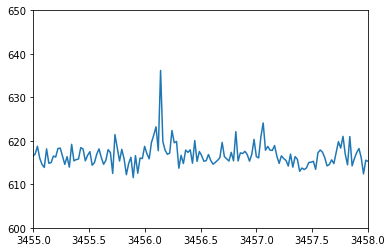

In [148]:
plt.plot(flc.time, flc.detrended_flux)
plt.xlim(3455, 3458)
plt.ylim(600,650)

## Create inspection suite and select true flares

Found 0 candidate(s) in the (0,617) gap.
Found 0 candidate(s) in the (617,2369) gap.


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec


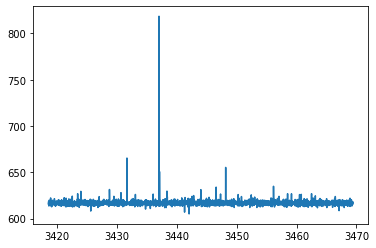

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
flc.flux[:] = flc.detrended_flux
flcd = flc.detrend("savgol", window_length=25)
plt.plot(flcd.time, flcd.detrended_flux)
flcd.detrended_flux_err[:] = flcd.detrended_flux.std()
flcd.find_flares().flares



In [130]:

interactive_vetting(df, ID, c, flc)

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series